In [419]:
! pip3 install pandas pycoingecko matplotlib scipy seaborn
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import datetime as dt
import time
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
from tqdm import tqdm
from pycoingecko import CoinGeckoAPI
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.formula.api import ols
from statsmodels.formula.api import wls
from statsmodels.iolib.summary2 import summary_col
from statsmodels.tsa.filters.hp_filter import hpfilter
from pandas.plotting import lag_plot

In [460]:
tweets_df = pd.read_csv('../data/crypto/tweets.csv')
tweets_df = tweets_df.astype({'timestamp': 'datetime64[ns]'})

In [547]:
class TweetStats:
    def __init__(self,twt_dt,df,coin,currency,creator):
        self.id = twt_dt
        self.df = df
        self.coin = coin
        self.currency = currency
        self.creator = creator
    
def get_all_tweet_dfs(twt_df,directory='../data/crypto/prices/'):
    tweet_dfs = []
    for _,row in twt_df.iterrows():
        coin = row['coin']
        currency = row['currency']
        creator = row['creator']
        timestamp = row['timestamp']
        filepath = directory + (creator.lower() + " " + coin + " vs " + currency + " " + str(timestamp) + " " + ".csv").replace(" ", "_")
        df = pd.read_csv(filepath)
        df = df.astype({'date': 'datetime64[ns]'})
        df = gen_extra_cols(df,timestamp)
        tweet_stats = TweetStats(timestamp,df,coin,currency,creator)
        tweet_dfs.append(tweet_stats)
    return tweet_dfs

In [548]:
def is_after_tweet(date,tweet_dt):
    if date < tweet_dt:
        return 0
    elif date > tweet_dt: 
        return 1
    else:
        pass
def days_since(date,tweet_dt):
    diff = date - tweet_dt
    return  diff.days + (diff.seconds / (3600 * 24))
def min_max(price,min_price,max_price):
    return (price - min_price)/(max_price-min_price)
def kernel(R,c,h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)
def gaussian_kernel(R,h,c=0):
    fraction = (1/(h*np.sqrt(2*np.pi)))
    exp = np.exp(-0.5*(((R-c)/h))**2)
    return fraction * exp

In [549]:
def gen_extra_cols(original_df,twt_dt,c=0,h=1):
    expanded_df = original_df.copy()
    expanded_df['before_after'] = expanded_df['date'].map(lambda x: is_after_tweet(x,twt_dt))
    expanded_df['days_since_tweet'] = expanded_df['date'].map(lambda x: days_since(x,twt_dt))
    expanded_df['min_max_prices'] = min_max(expanded_df['prices'],min(expanded_df['prices']),max(expanded_df['prices']))
    #expanded_df['kernel_weighting'] = expanded_df['days_since_tweet'].map(lambda x: kernel(x,c,h)) 
    #expanded_df['hp_prices'] = hp
    return expanded_df

In [550]:
all_tweet_stats = get_all_tweet_dfs(tweets_df)

In [551]:
def get_sub_df(original_df,twt_dt,window_size):
    sub_df = original_df.copy()
    sub_df['days_since_tweet'] = sub_df['date'].map(lambda x: days_since(x,twt_dt))
    sub_df = sub_df[(sub_df['days_since_tweet'] >= -window_size) & (sub_df['days_since_tweet'] <= window_size)].copy().reset_index(drop=True)
    return gen_extra_cols(sub_df,twt_dt)
def random_tweet_dt(original_df,window_size,asymmetry=False,d_bf=7,d_aft=2):
    if asymmetry:
        sample_from = original_df['date'][0] + dt.timedelta(days=d_bf)
        sample_to = original_df['date'][len(original_df.index)-1] - dt.timedelta(days=d_aft)
    else:
        sample_from = original_df['date'][0] + dt.timedelta(days=window_size)
        sample_to = original_df['date'][len(original_df.index)-1] - dt.timedelta(days=window_size)
    sampling_df = original_df[(original_df['date'] >= sample_from) & (original_df['date'] <= sample_to)]
    random_tweet = sampling_df.sample()
    random_tweet_date = original_df['date'][random_tweet.index.values.tolist()[0]]
    return random_tweet_date
def asymmetric_sub_df(original_df,twt_dt,days_before,days_after):
    sub_df = original_df.copy()
    sub_df['days_since_tweet'] = sub_df['date'].map(lambda x: days_since(x,twt_dt))
    sub_df = sub_df[(sub_df['days_since_tweet'] >= -days_before) & (sub_df['days_since_tweet'] <= days_after)]
    return gen_extra_cols(sub_df,twt_dt)

In [552]:
def multi_window_models(original_df,twt_dt,window_sizes=range(1,8),with_kernel=False,with_gaussian=False,asymmetry=False,d_bf=6,d_aft=0,only_back=False,only_forward=False):
    models = []
    names = []
    for w in window_sizes:
        if asymmetry:
            if only_back:
                window_df = asymmetric_sub_df(original_df,twt_dt,d_bf+w,d_aft)
            elif only_forward:
                window_df = asymmetric_sub_df(original_df,twt_dt,d_bf,d_aft+w)
            else:
                window_df = asymmetric_sub_df(original_df,twt_dt,d_bf+w,d_aft+w)
        else:
            window_df = get_sub_df(original_df,twt_dt,w)
            
        if with_kernel:
            model = wls('min_max_prices ~ days_since_tweet * before_after',
                        window_df,
                        weights=kernel(window_df['days_since_tweet'],c=0,h=w)).fit()
        elif with_gaussian:
            if asymmetry:
                model = wls('min_max_prices ~ days_since_tweet * before_after',
                            window_df,
                            weights=gaussian_kernel(window_df['days_since_tweet'],c=0,h=(d_bf+w)/2)).fit()
            else:
                model = wls('min_max_prices ~ days_since_tweet * before_after',
                           window_df,
                           weights=gaussian_kernel(window_df['days_since_tweet'],c=0,h=(w/2))).fit()
        else:
            model = ols('min_max_prices ~ days_since_tweet * before_after',window_df).fit()
                            
        models.append(model)
        if asymmetry:
            if only_back:
                names.append('- ' + str(d_bf+w) + ' + ' + str(d_aft) + ' Days')
            elif only_forward:
                names.append('- ' + str(d_bf) + ' + ' + str(d_aft+w) + ' Days')
            else:
                names.append('- ' + str(d_bf+w) + ' + ' + str(d_aft+w) + ' Days')
        else:
            names.append('± ' + str(w) + ' Days')
    return models, names
def multi_regression_tbl(models,names):
    return summary_col(
        models,
        stars=True,
        float_format='%0.3f',
        model_names=names,
        info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))})
def perform_multiple_multi_regressions(tws,window_sizes=range(1,10)):
    tables = {}
    #the keys of the dfs dictionary are the tweet timestamps
    for tweet_stats in tqdm (tws,desc="Performing multi window regressions..."):
        twt_dt = tweet_stats.id
        df = tweet_stats.df
        models, names = multi_window_models(df,twt_dt,window_sizes)
        results_table = multi_regression_tbl(models,names)
        tweet_stats.regression_models = models
        tweet_stats.model_names = names
        tweet_stats.results_table = results_table
        tables[twt_dt] = results_table
    return tables
        

In [553]:
multi_regress_tables = perform_multiple_multi_regressions(all_tweet_stats,window_sizes=range(1,15))

Performing multi window regressions...: 100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


In [578]:
def price_over_time_plot(df,model,title,xlabel="Days Since Tweet",ylabel="Min Max Asset Price"):
    ax = df.plot(y='min_max_prices',x='days_since_tweet')
    df.assign(predictions=model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax,color='C1')
    plt.axvline(0,color='green',linestyle='--')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(["Min Max Price","Regression Lines"])
    return plt
def produce_modelled_price_over_time_plots(tws):
    #again, the tweet timestamp is the key in this dictionary:
    plots = []
    for tweet_stats in tws:
        df = tweet_stats.df
        twt_dt = tweet_stats.id
        window_size = tweet_stats.chosen_window_size
        sub_df = get_sub_df(df,twt_dt,window_size)
        model = tweet_stats.chosen_model
        coin = tweet_stats.coin
        currency = tweet_stats.currency
        creator = tweet_stats.creator
        title = "Time Series of the Min Max Price of {coin} in {currency}\n Around the Days Since {creator}'s Tweet at {twt_dt}".format(coin=coin.title(),currency=currency.upper(),creator=creator.title(),twt_dt=str(twt_dt))
        p_o_t_plot = price_over_time_plot(sub_df,model,title)
        tweet_stats.chosen_model_plot = p_o_t_plot
        plots.append(p_o_t_plot)
    return plots

[<module 'matplotlib.pyplot' from '/home/clare/miniconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>]

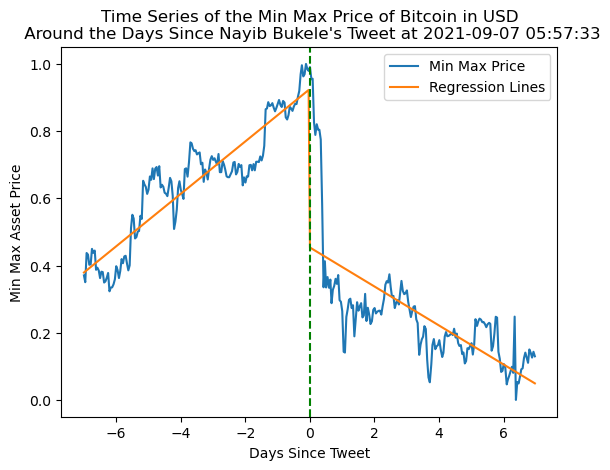

In [580]:
all_tweet_stats[0].chosen_model = all_tweet_stats[0].regression_models[6]
all_tweet_stats[0].chosen_window_size = 7
produce_modelled_price_over_time_plots([all_tweet_stats[0]])

In [607]:
def before_after_box_plot(df,coin,currency,creator,twt_dt):
    axes=df.groupby(by='before_after').boxplot(column='prices',subplots=True)
    #remove individual titles
    axes[0].set_title('')
    axes[1].set_title('')
    #set common super title
    title = "Comparative Box Plot of {coin} Prices in {currency} \n Before and After {creator}'s Tweet at {twt_dt}".format(coin=coin.title(),currency=currency.upper(),creator=creator.title(),twt_dt=str(twt_dt))
    plt.suptitle(title)
    #separate x labels
    axes[0].set_xticklabels(['{coin} Prices Before Tweet'.format(coin=coin.title())])
    axes[1].set_xticklabels(['{coin} Prices After Tweet'.format(coin=coin.title())])
    #common y label
    axes[0].set_ylabel("{coin} Prices in {currency}".format(coin=coin.title(),currency=currency.upper()))
    return axes
def produce_before_after_box_plots(tws):
    box_plots = []
    for tweet_stats in tws:
        df = tweet_stats.df
        coin = tweet_stats.coin
        currency = tweet_stats.currency
        creator = tweet_stats.creator
        twt_dt = tweet_stats.id
        window_size = tweet_stats.chosen_window_size
        sub_df = get_sub_df(df,twt_dt,window_size)
        box_plot = before_after_box_plot(sub_df,coin,currency,creator,twt_dt)
        box_plots.append(box_plot)
        tweet_stats.chosen_model_box_plot = box_plot
    return box_plots

[0         AxesSubplot(0.1,0.15;0.363636x0.75)
 1    AxesSubplot(0.536364,0.15;0.363636x0.75)
 dtype: object]

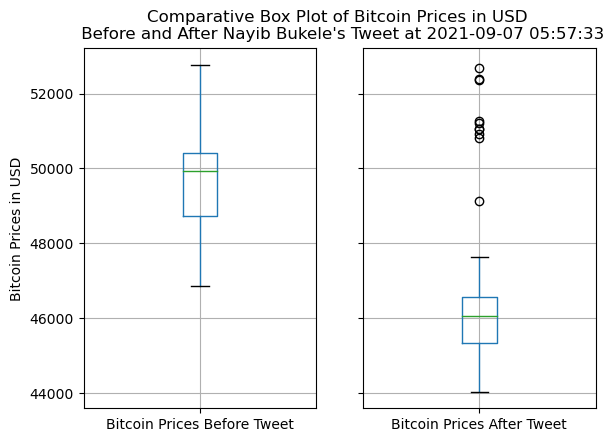

In [605]:
produce_before_after_box_plots([all_tweet_stats[0]])

In [611]:
def perform_placebos(original_df,window_size=7,n=100,with_kernel=False,with_gaussian=False,asymmetry=False,d_bf=7,d_aft=2):
    models = []
    for i in tqdm (range(n),desc="Performing placebos..."):
        rand_twt_dt = random_tweet_dt(original_df,window_size,asymmetry,d_bf,d_aft)
        if asymmetry:
            rand_window_df = asymmetric_sub_df(original_df,rand_twt_dt,d_bf,d_aft)
        else:
            rand_window_df = get_sub_df(original_df,rand_twt_dt,window_size)
        if with_kernel:
            model = wls('min_max_prices ~ days_since_tweet * before_after',
                        rand_window_df,
                        weights=kernel(rand_window_df['days_since_tweet'],c=0,h=window_size)).fit()
        if with_gaussian:
            model = wls('min_max_prices ~ days_since_tweet * before_after',
                        rand_window_df,
                        weights=gaussian_kernel(rand_window_df['days_since_tweet'],c=0,h=(d_bf/2))).fit()
            
        else:
            model = ols('min_max_prices ~ days_since_tweet * before_after',rand_window_df).fit()   
        models.append(model)
    return models
def produce_placebo_models(tws,n=1000):
    placebos = []
    for tweet_stats in tws:
        df = tweet_stats.df
        twt_dt = tweet_stats.id
        window_size = tweet_stats.chosen_window_size
        placebo_models = perform_placebos(df,window_size,n)
        tweet_stats.placebo_models = placebo_models
        placebos.append(placebo_models)
    return placebos
        

In [612]:
placebo_models = produce_placebo_models([all_tweet_stats[0]])

Performing placebos...: 100%|██████████| 1000/1000 [02:02<00:00,  8.17it/s]


In [629]:
placebo_models[0][0].params['before_after']

-0.05722965159489629

[<module 'matplotlib.pyplot' from '/home/clare/miniconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>]

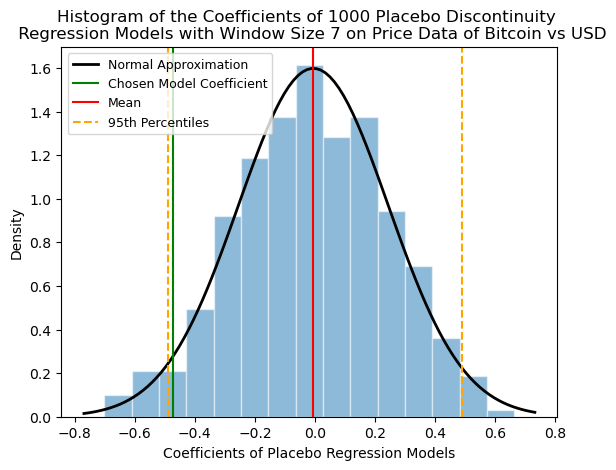

In [678]:
def produce_coeff_hist(placebos,coefficient,coin,currency,window_size,bins=15):
    placebo_coeffs = pd.Series(placebos).map(lambda x: x.params['before_after']).to_list()
    plt.hist(placebo_coeffs,alpha=0.5,bins=bins,edgecolor='white',density=True)

    mu, se = norm.fit(placebo_coeffs)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin,xmax,100)
    p = norm.pdf(x,mu,se)
    plt.plot(x,p,'k',linewidth=2)

    plt.axvline(coefficient,color='green')
    plt.axvline(mu,color='red')
    #plt.axvline(se,color='orange',linestyle='--')
    plt.axvline(1.96*se,color='orange',linestyle='--')
    #plt.axvline(-se,color='orange',linestyle='--')
    plt.axvline(-1.96*se,color='orange',linestyle='--')
    
    plt.title("Histogram of the Coefficients of {n} Placebo Discontinuity \n Regression Models with Window Size {window_size} on Price Data of {coin} vs {currency}".format(coin=coin.title(),n=str(len(placebo_coeffs)),currency=currency.upper(),window_size=window_size))
    plt.xlabel('Coefficients of Placebo Regression Models')
    plt.ylabel('Density')

    plt.legend(['Normal Approximation',"Chosen Model Coefficient",'Mean','95th Percentiles'],loc='upper left',fontsize=9)
    
    
    return plt
def produce_placebo_histograms(tws,bins=15):
    placebo_hists = []
    for tweet_stats in tws:
        placebo_models = tweet_stats.placebo_models
        chosen_model = tweet_stats.chosen_model
        chosen_model_coeff = chosen_model.params['before_after']
        window_size = tweet_stats.chosen_window_size
        coin = tweet_stats.coin
        currency= tweet_stats.currency
        histogram = produce_coeff_hist(placebo_models,chosen_model_coeff,coin,currency,window_size,bins)
        tweet_stats.placebo_hist = histogram
        placebo_hists.append(histogram)
    return placebo_hists

#test_plot = produce_coeff_hist(placebos,-0.472,'bitcoin','usd',7)
produce_placebo_histograms([all_tweet_stats[0]])

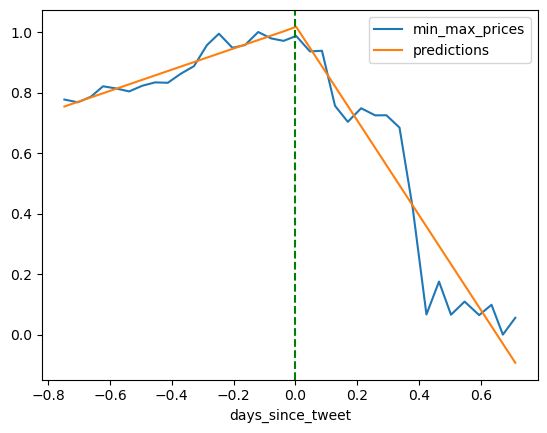

In [330]:
one_day = get_sub_df(df,tweet_datetime,0.75)
one_day_model = ols('min_max_prices ~ days_since_tweet * before_after',one_day).fit()
ax = one_day.plot(y='min_max_prices',x='days_since_tweet',kind="line")
one_day.assign(predictions=one_day_model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax,color='C1')
plt.axvline(0,color='green',linestyle='--')

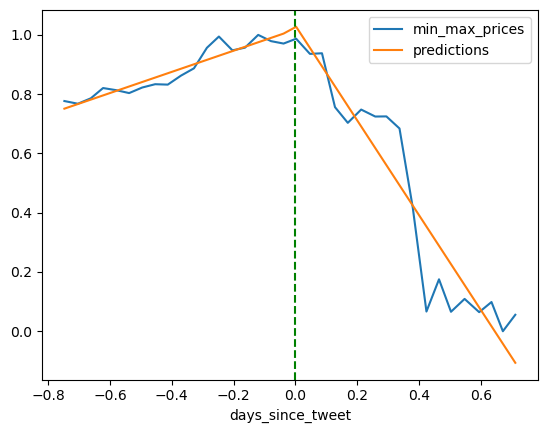

In [303]:
one_day_w_model = wls('min_max_prices ~ days_since_tweet * before_after',one_day,weights=gaussian_kernel(one_day['days_since_tweet'],c=0,h=0.5)).fit()
ax_w1 = one_day.plot(y='min_max_prices',x='days_since_tweet')
one_day.assign(predictions=one_day_w_model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax_w1,color='C1')
plt.axvline(0,color='green',linestyle='--')

In [306]:
prices_cycle, prices_trend = hpfilter(seven_days['prices'],lamb=50)

<AxesSubplot:>

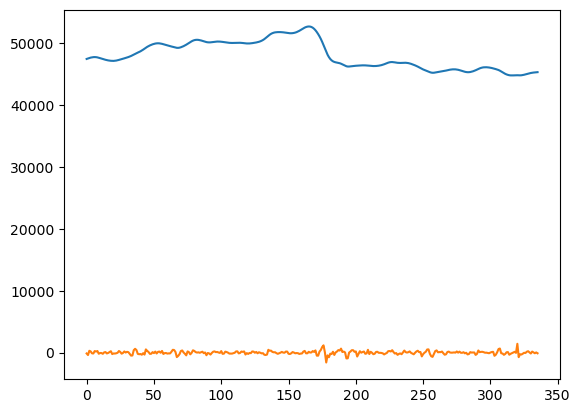

In [307]:
prices_trend.plot()
prices_cycle.plot()

In [308]:
one_day['hp_min_max'] = hpfilter(one_day['min_max_prices'],lamb=10)[1]

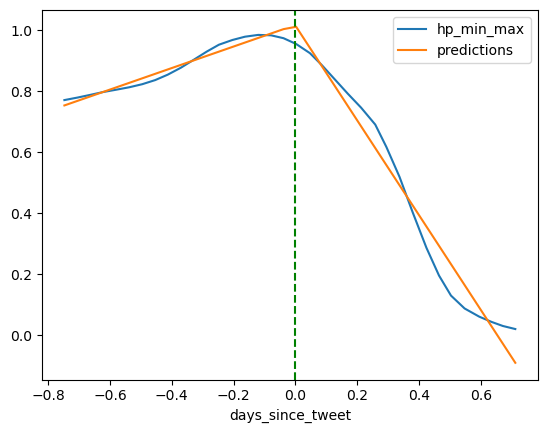

In [309]:
one_day_hp_m = ols('hp_min_max ~ days_since_tweet * before_after',one_day).fit()
ax = one_day.plot(y='hp_min_max',x='days_since_tweet')
one_day.assign(predictions=one_day_hp_m.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax,color='C1')
plt.axvline(0,color='green',linestyle='--')